<a href="https://colab.research.google.com/github/river6907/Data-Mining/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_samples, silhouette_score

# K-means



## 붓꽃 데이터 군집화

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()

In [ ]:
model = cluster.KMeans(n_clusters=3)
model.fit(iris.data)
labels = model.predict(iris.data)
print('결과 labels : ', labels)

결과 labels :  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


In [ ]:
a_counts = np.bincount(labels[:50])
b_counts = np.bincount(labels[50:100])
c_counts = np.bincount(labels[100:])

print(a_counts)
print(b_counts)
print(c_counts)

[ 0 50]
[48  0  2]
[14  0 36]


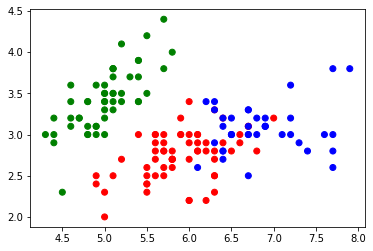

In [ ]:
colors = np.array(['red','green','blue'])
plt.scatter(iris.data[:, 0], iris.data[:, 1], color = colors[labels]);

# UCL online retail 데이터 군집화

## 데이터 준비

In [ ]:
from google.colab import files
files.upload()

Saving Online Retail.xlsx to Online Retail (2).xlsx


In [ ]:
retail_df = pd.read_excel('Online Retail.xlsx')
retail_df.head()

In [ ]:
retail_df.info()

## 데이터 정제

* CustomerID 형변환(실수 -> 정수)
* CustomerID 결측치 제거
* 중복 레코드 제거
* Quantity, UnitPrice가 음수인 것 제외



In [ ]:
#데이터 정제해보자

In [ ]:
retail_df.isnull().sum()

In [ ]:
retail_df.query('Quantity < 0 or UnitPrice < 0') #Quantity, UnitPrice가 음수인 것 제외

In [ ]:
retail_df = retail_df.dropna() 
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int) #정수형으로 전환
retail_df = retail_df.query('Quantity > 0 and UnitPrice > 0')
retail_df.drop_duplicates(inplace=True) #중복 제거 중복제거한 결과를 반영할것인지 # 중복제거한 다음에 df 만듬
retail_df.info()

In [ ]:
retail_df.shape

In [ ]:
retail_df['SaleAmount'] = retail_df.UnitPrice * retail_df.Quantity
retail_df.head()

In [ ]:
aggs = {'InvoiceNo':'count', 'SaleAmount':'sum', 'InvoiceDate': 'max'}

customer_df = retail_df.groupby('CustomerID').agg(aggs) # 집계함수를 적용 #쵝근 날짜 적용
customer_df = customer_df.reset_index() 
customer_df.head()

In [ ]:
customer_df = customer_df.rename(columns={'InvoiceNo':'Freq', 'InvoiceDate':'ElapsedDays'})
customer_df.head()

In [ ]:
import datetime
customer_df['ElapsedDays'] = datetime.datetime(2011, 12, 10) - customer_df['ElapsedDays'] #기준일로 며칠전인지 나타냄 즉 경과일
customer_df.head()

In [ ]:
customer_df['ElapsedDays'] = customer_df['ElapsedDays'].apply(lambda x: x.days + 1) #람다 적용해서 결과를 날짜로 적용
customer_df.head()

## 데이터 전처리

In [ ]:
# log transform 클러스터링 전 전처리룰 해본다 -> 표준화 0인 경우에도 로그값 취하기 위해 log1p해준다.
customer_df['Freq_log'] = np.log1p(customer_df['Freq']) #값이 0일때1로 값을 처리해 값이 0 나오게 한다.
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])
customer_df.head()

In [ ]:
# scaling
X = customer_df[['Freq_log', 'SaleAmount_log', 'ElapsedDays_log']].values
scaled_X = StandardScaler().fit_transform(X)

## 군집화

In [ ]:
# elbow 방법으로 k 구하기  # 1개부터 10개까지 응집도를 구해보니 
distortions = []
for k in range(1, 11):
  kmeans_k = KMeans( n_clusters = k, random_state = 0 )
  kmeans_k.fit(scaled_X)
  distortions.append(kmeans_k.inertia_) #INERTIA 속성값사용

plt.plot(range(1, 11), distortions, marker='o') #왜곡값 계산 
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show();

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
y= kmeans.fit_predict(scaled_X)

In [ ]:
customer_df['ClusterLabel']=y #예측결과 labeldmf 저기에 저장
customer_df.head()

## 결과 시각화 및 분석
 * 실루엣 분석
  * 클러스터 내 데이터의 응집도를 측정
  * a(i) : 클러스터 응집력
    * 데이터 i가 해당 클러스터 내의 데이터와 얼마나 가까운지 알 수 있다.
  * b(i) : 클러스터 분리도
    * 가장 가까운 다른 클러스터 내의 데이터와 얼마나 떨어져 있는지 알 수 있다.
  * -1 ~ 1 사이의 값을 가지며 1에 가까울수록 좋은 군집화 

s(x) = b(i) − a(i) / max(a(i), b(i))

In [ ]:
from matplotlib import cm
def clusterScatter(n_cluster, X_features):
  c_colors = []
  kmeans = KMeans(n_clusters=n_cluster, random_state=0)
  Y_labels = kmeans.fit_predict(X_features)

  for i in range(n_cluster):
      c_color = cm.jet(float(i) / n_cluster) #cm=colormap 
      c_colors.append(c_color)
      plt.scatter(X_features[Y_labels == i, 0], X_features[Y_labels == i, 1],
                 marker='o', color=c_color, edgecolor='k', s=50, label='cluster ' + str(i))
 # center값 찾아서 찍어줄꺼고 (^ 삼각형으로) 찍히고
  for i in range(n_cluster):
      plt.scatter(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1],
                  marker='^', color=c_colors[i], edgecolor='w', s=200)
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.show()

In [ ]:
def silhouetteViz(n_cluster, X_features):
  kmeans = KMeans(n_clusters=n_cluster, random_state=0)
  Y_labels = kmeans.fit_predict(X_features)
  silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean')
  silhouette_avg = np.mean(silhouette_values)
  print('k={0:d} 일 때 Silhouette Score : {1: .3f}'.format(n_cluster, silhouette_avg))

In [ ]:
clusterScatter(3, scaled_X)

In [ ]:
clusterScatter(4, scaled_X)

In [ ]:
clusterScatter(5, scaled_X)

In [ ]:
clusterScatter(6, scaled_X)

## 군집 분석의 활용 예


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
y_labels = kmeans.fit_predict(scaled_X)
customer_df['Clusterlabel'] = y_labels
customer_df.head()

In [ ]:
customer_df.groupby('Clusterlabel')['CustomerID'].count()

In [ ]:
# 총 구매 빈도, 총 구매 금액, 마지막 구매 이후 경과일 추출
cust_cluster_df = customer_df.drop(['Freq_log', 'SaleAmount_log', 'ElapsedDays_log', 'ClusterLabel'], axis=1, inplace=False)
cust_cluster_df.head()

In [ ]:
# 구매 1회당 평균 구매 금액 계산
cust_cluster_df['SaleAmountAvg'] = cust_cluster_df.SaleAmount / cust_cluster_df.Freq
cust_cluster_df.drop(['CustomerID'], axis=1, inplace=False).groupby('Clusterlabel').mean()

# K-means vs. DBSCAN


## 데이터 생성


In [ ]:
np.random.seed(0)
n_samples = 1500
random_state = 0
noise = 0.05

In [ ]:
circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=noise, random_state=random_state)
moons = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
no_structures = np.random.rand(n_samples, 2), None

In [ ]:
def fit_predict_plot(model, dataset, position, title):
  X, y = dataset
  model.fit(X)

  if hasattr(model, 'labels_'):
    labels = model.labels_.astype(np.int)
  else:
    labels = model.predict(X)

  colors = np.array(['orange', 'yellowgreen', 'royalblue', 'darkred', 'purple', 'olivegreen', 'lightblue'])
  ax = plt.subplot(position)
  ax.set_title(title)
  ax.scatter(X[:, 0], X[:, 1], color=colors[labels])  

## k-means

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('k-means (k=2)')
fit_predict_plot(cluster.KMeans(n_clusters=2, random_state=random_state), circles, 221, 'Circles')
fit_predict_plot(cluster.KMeans(n_clusters=2, random_state=random_state), moons, 222, 'moons')
fit_predict_plot(cluster.KMeans(n_clusters=2, random_state=random_state), blobs, 223, 'blobs')
fit_predict_plot(cluster.KMeans(n_clusters=2, random_state=random_state), no_structures, 224, 'no_structures')

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('k-means (k=3)')
fit_predict_plot(cluster.KMeans(n_clusters=3, random_state=random_state), circles, 221, 'Circles')
fit_predict_plot(cluster.KMeans(n_clusters=3, random_state=random_state), moons, 222, 'moons')
fit_predict_plot(cluster.KMeans(n_clusters=3, random_state=random_state), blobs, 223, 'blobs')
fit_predict_plot(cluster.KMeans(n_clusters=3, random_state=random_state), no_structures, 224, 'no_structures')

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('k-means (k=4)')
fit_predict_plot(cluster.KMeans(n_clusters=4, random_state=random_state), circles, 221, 'Circles')
fit_predict_plot(cluster.KMeans(n_clusters=4, random_state=random_state), moons, 222, 'moons')
fit_predict_plot(cluster.KMeans(n_clusters=4, random_state=random_state), blobs, 223, 'blobs')
fit_predict_plot(cluster.KMeans(n_clusters=4, random_state=random_state), no_structures, 224, 'no_structures')

## DBSCAN

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('DBSCAN')
fit_predict_plot(cluster.DBSCAN(eps=.3), circles, 221, 'Circles')
fit_predict_plot(cluster.DBSCAN(eps=.3), moons, 222, 'moons')
fit_predict_plot(cluster.DBSCAN(eps=.3), blobs, 223, 'blobs')
fit_predict_plot(cluster.DBSCAN(eps=.3), no_structures, 224, 'no_structures')

# DBSCAN -> iris data


In [ ]:
from sklearn.cluster import DBSCAN
iris = load_iris(as_frame=True)
iris.frame.head()

In [ ]:
data = pd.DataFrame(iris.data)
target = pd.DataFrame(iris.target)
data.columns = ['Sepal_L', 'Sepal_W', 'Petal_L', 'Petal_W']
target.columns = ['target']

In [ ]:
db = DBSCAN(eps=0.6, min_samples=8).fit(data)
labels = db.labels_

In [ ]:
labels # -1 값은 노이즈를 의미한다.

In [ ]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # -1이면 그 값을 뺀다 아님 그냥 둔다
n_noise = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)
print('Silhouette Coefficient: %.3f' % metrics.silhouette_score(data, labels))

적절한 입실론 값과 최소 샘플 수를 찾는다

In [ ]:
db = DBSCAN(eps=0.8, min_samples=8).fit(data)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)
print('Silhouette Coefficient: %.3f' % metrics.silhouette_score(data, labels))

In [ ]:
db = DBSCAN(eps=0.6, min_samples=16).fit(data)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)
print('Silhouette Coefficient: %.3f' % metrics.silhouette_score(data, labels))

## Hierarachical Clustering

 https://todayisbetterthanyesterday.tistory.com/59


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster 
# 적절한 단계로 cut할때 쓰는 fcluster #메소드 뭔가 중요해보임

In [ ]:
iris.frame.head()

In [ ]:
data = pd.DataFrame(iris.data)
target = pd.DataFrame(iris.target)
data.columns = ['Sepal_L', 'Sepal_W', 'Petal_L', 'Petal_W']
target.columns = ['target']

In [ ]:
mergings = linkage(data, method='complete')
plt.figure(figsize=(40, 20))
dendrogram(mergings,
labels=target.values,
leaf_rotation=90,
leaf_font_size=20)
plt.show();
# 3수준으로 자르면 4개로 나뉨 

In [ ]:
predict = pd.DataFrame(fcluster(mergings, 3, criterion='distance')) #사용하는 클러스터는 merging
predict.columns = ['predict']
ct = pd.crosstab(predict['predict'], target['target'])
print(ct)

In [ ]:
predict = pd.DataFrame(fcluster(mergings, 4, criterion='distance'))
predict.columns = ['predict']
ct = pd.crosstab(predict['predict'], target['target'])
print(ct)